## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [1]:
#import libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Read the dataset

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows

In [3]:
df.shape[0]

294478

The number of unique users

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

Check missing values: 

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  So, I will remove these rows to avoid inconsistencies in results. 

In [8]:
df2 = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))

In [9]:
# Double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Check df2

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


The unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The row information for the **user_id** = 773192

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**

In [14]:
df2 = df2.drop(df2[df2.duplicated(['user_id'])].index)

In [15]:
#check outcome

df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [16]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


The probability of an individual converting regardless of the page they receive

In [17]:
df2.query('converted == 1').shape[0] / df2.shape[0]

0.11959708724499628

The probability converted given that an individual was in the `control` group

In [18]:
control = df2.query('group == "control"').shape[0]

df2.query('group == "control" & converted == 1').shape[0] / control

0.1203863045004612

The probability converted given that an individual was in the `treatment` group

In [19]:
treatment = df2.query('group == "treatment"').shape[0]

df2.query('group == "treatment" & converted == 1').shape[0] / treatment

0.11880806551510564

The probability that an individual received the new page

In [20]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

The conversion of the new treatment page is actually lower. The difference is too small (0.16%), almost negligible. Thus, there is no sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  


Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, we state our null and alternative hypothesis as follows:-

$$H_0: p_{new} - p_{old}\leq 0  $$

$$H_1: p_{new} - p_{old} > 0 $$

**Assumptions**

- Under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. 

- Assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

The **convert rate** for $p_{new}$ under the null.

In [21]:
p_null = df2.converted.mean()
p_null

0.11959708724499628

The **convert rate** for $p_{old}$ under the null.

In [22]:
p_null

0.11959708724499628

$n_{new}$

In [23]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

$n_{old}$

In [24]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(1, p_null, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, p_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.002441264796006773

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process. Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []


for _ in range (10000): 
    new_page_converted = np.random.binomial(1, p_null, n_new)
    old_page_converted = np.random.binomial(1, p_null, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs = np.array(p_diffs)

In [29]:
control_convert = df2.query('group == "control"')['converted'].mean()
treatment_convert = df2.query('group == "treatment"')['converted'].mean()
obs_diffs = treatment_convert - control_convert
obs_diffs

-0.0015782389853555567

Plot a histogram of the **p_diffs**

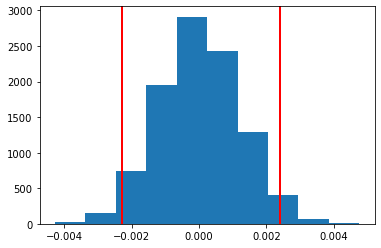

In [30]:
#view 95% confidence interval 

low, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

plt.hist(p_diffs)
plt.axvline(x=low, color='red', linewidth = 2)
plt.axvline(x=upper, color='red', linewidth = 2);

The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [31]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

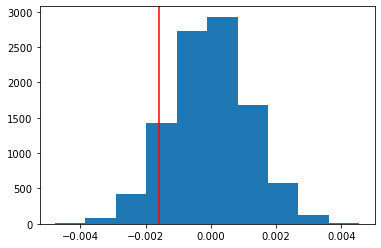

In [32]:
plt.hist(null_vals)
plt.axvline(obs_diffs, color='red');

In [33]:
# compute p-value

(null_vals > obs_diffs).mean()

0.9033

This value is p-values, it is the probability of observing data or more extreme data. It is notated as alpha, also known as the threshold for the percentage we are willing to commit a Type I error.

- Type I errors occur when choosing the alternative when null is true.
- Type II errors occur when choosing the null when alternative is true.
- Since the p-value is large (0.9017), we do not have statistical evidence to suggest the new page has a better conversion rate. Thus, we fail to reject the null hypothesis.

##### We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Steps to calculate the statistical significance:
- calculate the number of conversions for each page
- calculate the number of individuals who received each page
- Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

Now use `stats.proportions_ztest` to compute test statistic and p-value.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old,n_new], alternative='smaller')
z_score,p_value

(1.3109241984234394, 0.9050583127590245)

At alpha = 0.05, the z-score computed is less than the critical value of 1.64 and thus we fail to reject the null hypothesis.

The p-value (0.905) is larger than 0.05, therefore we can deduce that there is NO statistical significance to suggest that new page has better conversion rate. 

Thus, we fail to reject the null.

<a id='regression'></a>
### Part III - A regression approach

The result we achieved in the previous A/B test can also be achieved by performing regression.

Since we would like to predict whether a user will convert or not, which is a binary variable, thus Logistic Regression can be used in this case.

The goal is to use **statsmodels** to fit the regression model, to see if there is a significant difference in conversion based on which page a customer receives.  

Steps in regression approach:-
- Create a column for the intercept
- create a dummy variable column for which page each user received.  
- Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1

In [37]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.tail(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0,1,1
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0,1,1
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0,1,1
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0,1,1
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1


In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


Use **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created earlier to predict whether or not an individual converts.

In [39]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-06-03 15:36 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In regression, the p-value is used for testing if a parameter (intercept or slope) is equal to 0 or not equal to 0.

H0 : parameter = 0

H1 : parameter != 0

If p-value is small enough (<0.05), thus the parameter is statistically siginificance in relating to the dependent variable.

In our regression model, the p-value for:-

intercept (old page): 0.000

- old page is the baseline, p-value = 0.00 indicates this is statistically significance.

ab_page (new page): 0.1899

- indicates this is not statistically significance.


These p-values is different from Part II as the p-values in Part II follows our null hypothesis in AB testing. On the other hand, the p-values in our regression model suggest that whether the parameters is statistically significance relating to the slope

It is a good idea to consider other factors which might be useful in predicting the conversion. Since the current model only incorporated single factor (old/new page) for conversion.

However, one of the disadvantage we need to aware of is the collinearity. To avoid this, we can apply sb.pairplot to compare he X variables and VIFs to remove one of the variables that are strongly related (VIF > 10)

##### Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. Does it appear that the country had an impact on conversion? 

Now, we will read the file and merge together with df2. 

In [40]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [45]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [46]:
### Create the necessary dummy variables

df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [47]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_page'] = df_new['US'] * df_new['ab_page']

In [48]:
#fit linear model and get summary results.

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA_page', 'UK_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212779.0384
Date:               2021-06-03 15:42 BIC:              212810.7773
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.080850   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_page      -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_page       0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

In [49]:
np.exp(results.params)

intercept    0.135840
CA_page      0.927579
UK_page      1.015000
dtype: float64

In [50]:
1/np.exp(results.params)

intercept    7.361591
CA_page      1.078076
UK_page      0.985222
dtype: float64

From this model, we found out that CA_page is statistically significant. The results suggest that a user from Canada who gets a new page would be 1.08 less likely to convert compared to a user in US. However, the amount is too small and is not practically significance.

To conclude, we do not have much statistical evidence to prove that new page has a higher conversion rate than old page. We would suggest **not to switch to new page**.